Les Import

In [1]:
%pip install scikit-learn pandas matplotlib ipywidgets IPython

Note: you may need to restart the kernel to use updated packages.


In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas as pd
import plotly.graph_objects as go
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import IntText, Text, Button, VBox, HBox


I - Préparation des Données 

In [11]:
def prepare_data(file_path):
    # Chargement des données
    donnees = pd.read_csv(file_path)

    # Sélection des colonnes pertinentes
    data = donnees[['latitude', 'longitude', 'haut_tot']]

    # Normalisation des données
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data[['haut_tot']])

    return data, data_scaled

Normalisation des données numériques, utilisation du standardScaler. Il a pour but de ramener la moyenne μ à 0 et l’écart-type σ à 1.

In [12]:

data, data_scaled = prepare_data('Data_Arbre.csv')


II - Apprentissage Non Supervisé 

In [13]:
def k_mean(data_scaled, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(data_scaled)
    return clusters

In [14]:
def agglomerative_clustering(data_scaled , n_clusters):
    clustering = AgglomerativeClustering(n_clusters, linkage='ward')
    clusters = clustering.fit_predict(data_scaled)
    return clusters

In [15]:
# Calcul des clusters pour 2 et 3 clusters avec KMeans
clusters_kmeans_2 = k_mean(data_scaled, 2)
clusters_kmeans_3 = k_mean(data_scaled, 3)

# Calcul des clusters pour 2 et 3 clusters avec Agglomerative Clustering
clusters_agglom_2 = agglomerative_clustering(data_scaled, 2)
clusters_agglom_3 = agglomerative_clustering(data_scaled, 3)

III - Métriques pour l'Apprentissage Non Supervisé 

In [16]:
def trouve_meilleur_cluster(data_scaled, max_k):
    iters = range(2, max_k+1) # créer un intervalle qui va 2 au nombre maximal de cluster a tester
    sse = []#stock les valeur de l'inertie
    silhouette_scores = []#stock les valeurs des silhouette

    for k in iters:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data_scaled)
        sse.append(kmeans.inertia_)#calcule de l'inertie (distance entre les points et le centre du cluster
        score = silhouette_score(data_scaled, kmeans.labels_)#le score de silhouette mesure la cohésion et la séparation des clusters.
        silhouette_scores.append(score)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    fig.suptitle('Le nombre optimal de cluster ')

    ax1.plot(iters, sse, marker='o')
    ax1.set_xlabel('Nombre de Clusters')
    ax1.set_ylabel('SSE')
    ax1.set_title('Methode du coude')

    ax2.plot(iters, silhouette_scores, marker='o')
    ax2.set_xlabel('Nombre de Clusters')
    ax2.set_ylabel('Silhouette Score')
    ax2.set_title('Silhouette Scores')

    plt.show()


In [17]:
def evaluate_clusters(data_scaled, clusters):
    # Évaluation des clusters
    silhouette_avg = silhouette_score(data_scaled, clusters)
    # Justification : Le Silhouette Score évalue la qualité des clusters en termes de séparation et de cohésion
    print(f'Silhouette Score: {silhouette_avg}')
    return silhouette_avg


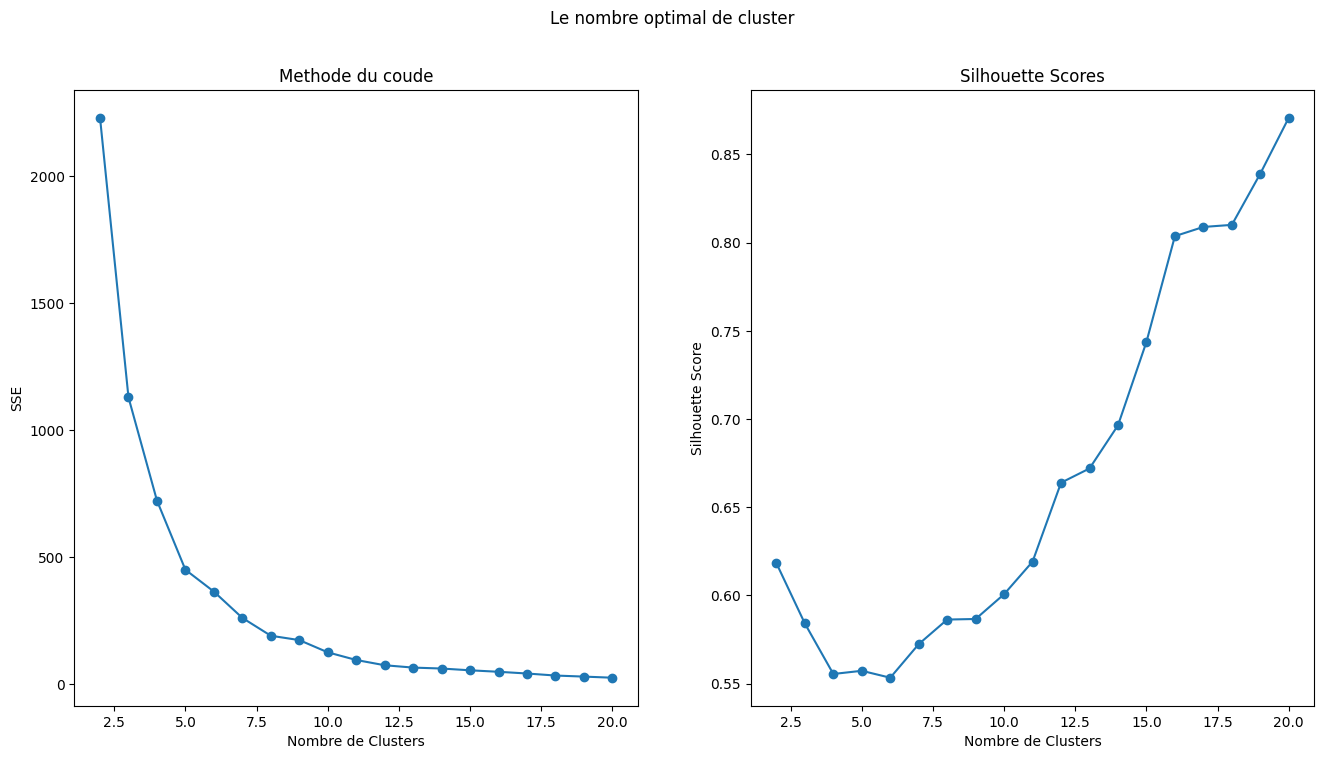

Silhouette Score: 0.6183070397058021


In [18]:
trouve_meilleur_cluster(data_scaled, 20)
silhouette_avg = evaluate_clusters(data_scaled, clusters_kmeans_2)

Pour choisir le nombre de cluster on peut utiliser :

La Méthode du coude ( 1er graphique)
Elle est basée sur le fait que la somme de la variance intraclusters peut être réduite grâce à l'augmentation du nombre de clusters. Plus il est élevé, plus il permet d'extraire des groupes plus fins à partir de l'analyse d'objets de données qui ont plus de similarité entre eux. On utilise le point de retournement de la courbe de la somme des variances pour choisir le bon nombre de clusters.

Le Score de silhouette( 2ème graphique)
Cette méthode permet d'évaluer la qualité des clusters créés grâce aux algorithmes de clustering. Pour ce faire, on considère la valeur de « k » ayant le score de silhouette le plus proche de 1.

In [19]:
n_clusters = int(input("Entrez le nombre de clusters souhaité: "))

In [20]:
labels_user = ['Cluster ' + str(i) for i in range(n_clusters)]

# Ajout des étiquettes de clusters
labels_2 = ['Petit', 'Grand']
labels_3 = ['Petit', 'Moyen', 'Grand']


In [21]:
def add_cluster_labels(data, clusters, labels):
    data['Cluster'] = clusters
    data['Cluster Label'] = data['Cluster'].apply(lambda x: labels[x])
    return data


In [22]:
clusters_kmeans_user = k_mean(data_scaled, n_clusters)
clusters_agglom_user = agglomerative_clustering(data_scaled, n_clusters)


data_kmeans_2 = add_cluster_labels(data.copy(), clusters_kmeans_2, labels_2)
data_kmeans_3 = add_cluster_labels(data.copy(), clusters_kmeans_3, labels_3)
data_agglom_2 = add_cluster_labels(data.copy(), clusters_agglom_2, labels_2)
data_agglom_3 = add_cluster_labels(data.copy(), clusters_agglom_3, labels_3)
data_kmeans_user = add_cluster_labels(data.copy(), clusters_kmeans_user, labels_user)
data_agglom_user = add_cluster_labels(data.copy(), clusters_agglom_user, labels_user)


IV - Visualisation sur carte 

In [23]:
fig = go.Figure()

# Add scatter traces
fig.add_trace(go.Scattermapbox(
    lat=data_kmeans_user['latitude'],
    lon=data_kmeans_user['longitude'],
    mode='markers',
    marker=dict(
        size=8,
        color=data_kmeans_user['Cluster'],
        colorscale='Viridis',
        opacity=0.8,
        showscale=True,
        colorbar=dict(
            title="Cluster",
            tickvals=list(range(n_clusters)),
            ticktext=labels_user
        )
    ),
    text=data_kmeans_user['Cluster Label'],
    hoverinfo='text',
    name=f'KMeans {n_clusters} Clusters'
))

fig.add_trace(go.Scattermapbox(
    lat=data_kmeans_2['latitude'],
    lon=data_kmeans_2['longitude'],
    mode='markers',
    marker=dict(
        size=8,
        color=data_kmeans_2['Cluster'],
        colorscale='Viridis',
        opacity=0.8,
        showscale=True,
        colorbar=dict(
            title="Cluster",
            tickvals=[0, 1],
            ticktext=labels_2
        )
    ),
    text=data_kmeans_2['Cluster Label'],
    hoverinfo='text',
    name='KMeans 2 Clusters',
    visible=False
))

fig.add_trace(go.Scattermapbox(
    lat=data_kmeans_3['latitude'],
    lon=data_kmeans_3['longitude'],
    mode='markers',
    marker=dict(
        size=8,
        color=data_kmeans_3['Cluster'],
        colorscale='Viridis',
        opacity=0.8,
        showscale=True,
        colorbar=dict(
            title="Cluster",
            tickvals=[0, 1, 2],
            ticktext=labels_3
        )
    ),
    text=data_kmeans_3['Cluster Label'],
    hoverinfo='text',
    name='KMeans 3 Clusters',
    visible=False
))

fig.add_trace(go.Scattermapbox(
    lat=data_agglom_2['latitude'],
    lon=data_agglom_2['longitude'],
    mode='markers',
    marker=dict(
        size=8,
        color=data_agglom_2['Cluster'],
        colorscale='Viridis',
        opacity=0.8,
        showscale=True,
        colorbar=dict(
            title="Cluster",
            tickvals=[0, 1],
            ticktext=labels_2
        )
    ),
    text=data_agglom_2['Cluster Label'],
    hoverinfo='text',
    name='Agglomerative 2 Clusters',
    visible=False
))

fig.add_trace(go.Scattermapbox(
    lat=data_agglom_3['latitude'],
    lon=data_agglom_3['longitude'],
    mode='markers',
    marker=dict(
        size=8,
        color=data_agglom_3['Cluster'],
        colorscale='Viridis',
        opacity=0.8,
        showscale=True,
        colorbar=dict(
            title="Cluster",
            tickvals=[0, 1, 2],
            ticktext=labels_3
        )
    ),
    text=data_agglom_3['Cluster Label'],
    hoverinfo='text',
    name='Agglomerative 3 Clusters',
    visible=False
))

fig.add_trace(go.Scattermapbox(
    lat=data_agglom_user['latitude'],
    lon=data_agglom_user['longitude'],
    mode='markers',
    marker=dict(
        size=8,
        color=data_agglom_user['Cluster'],
        colorscale='Viridis',
        opacity=0.8,
        showscale=True,
        colorbar=dict(
            title="Cluster",
            tickvals=list(range(n_clusters)),
            ticktext=labels_user
        )
    ),
    text=data_agglom_user['Cluster Label'],
    hoverinfo='text',
    name=f'Agglomerative {n_clusters} Clusters',
    visible=False
))

# Initial layout setup
fig.update_layout(
    autosize=True,
    hovermode='closest',
    mapbox=dict(
        style='carto-positron',
        bearing=0,
        center=dict(
            lat=49.84889,
            lon=3.28757
        ),
        pitch=0,
        zoom=13
    ),
    updatemenus=[
        dict(
            buttons=list([
                dict(
                    args=[{"visible": [True, False, False, False, False, False]}],
                    label=f"KMeans {n_clusters} clusters",
                    method="update"
                ),
                dict(
                    args=[{"visible": [False, True, False, False, False, False]}],
                    label="KMeans 2 clusters",
                    method="update"
                ),
                dict(
                    args=[{"visible": [False, False, True, False, False, False]}],
                    label="KMeans 3 clusters",
                    method="update"
                ),
                dict(
                    args=[{"visible": [False, False, False, True, False, False]}],
                    label="Agglomerative 2 clusters",
                    method="update"
                ),
                dict(
                    args=[{"visible": [False, False, False, False, True, False]}],
                    label="Agglomerative 3 clusters",
                    method="update"
                ),
                dict(
                    args=[{"visible": [False, False, False, False, False, True]}],
                    label=f"Agglomerative {n_clusters} clusters",
                    method="update"
                )
            ]),
            type="buttons",
            direction="right",
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0.1,
            xanchor="left",
            y=1.1,
            yanchor="top"
        )
    ],
    annotations=[
        dict(text="Nombre de clusters:", showarrow=False,
             x=0, y=1.15, yref="paper", align="left")
    ]
)

fig.show()
